In [1]:
input_image_size = 128

data_folder = r"radius1a"
ultrasound_file = r"ultrasound.npy"
segmentation_file = r"segmentation.npy"

test_ultrasound_file = r"ultrasound-test.npy"  # Set to None to skip testing
test_segmentation_file = r"segmentation-test.npy"

from local_vars import root_folder

In [2]:
import numpy as np
import os 

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

Using TensorFlow backend.


In [3]:
data_fullpath = os.path.join(root_folder, data_folder)

ultrasound_fullname = os.path.join(data_fullpath, ultrasound_file)
segmentation_fullname = os.path.join(data_fullpath, segmentation_file)

print("Reading ultrasound images from:  {}".format(ultrasound_fullname))
print("Reading segmentations from:      {}".format(segmentation_fullname))

ultrasound_data = np.load(ultrasound_fullname)
segmentation_data = np.load(segmentation_fullname)

num_ultrasound = ultrasound_data.shape[0]
num_segmentation = segmentation_data.shape[0]

print("\nFound {} ultrasound images and {} segmentations".format(num_ultrasound, num_segmentation))

Reading ultrasound images from:  c:\Temp\radius1a\ultrasound.npy
Reading segmentations from:      c:\Temp\radius1a\segmentation.npy

Found 2408 ultrasound images and 2408 segmentations


In [11]:
num_test_ultrasound = 0
num_test_segmentation = 0

if test_ultrasound_file is not None:
    test_ultrasound_fullname = os.path.join(data_fullpath, test_ultrasound_file)
    test_segmentation_fullname = os.path.join(data_fullpath, test_segmentation_file)
    print("Reading test ultrasound from: {}".format(test_ultrasound_fullname))
    print("Reading test segmentation from : {}".format(test_segmentation_fullname))
    test_ultrasound_data = np.load(test_ultrasound_fullname)
    test_segmentation_data = np.load(test_segmentation_fullname)
    num_test_ultrasound = test_ultrasound_data.shape[0]
    num_test_segmentation = test_segmentation_data.shape[0]
    print("\nFound {} test ultrasound images and {} segmentations".format(num_test_ultrasound, num_test_segmentation))

Reading test ultrasound from: c:\Temp\radius1a\ultrasound-test.npy
Reading test segmentation from : c:\Temp\radius1a\segmentation-test.npy

Found 268 test ultrasound images and 268 segmentations


In [5]:
feature_n = 512
step_size = 1e-4

def unet(pretrained_weights = None, input_size = (input_image_size, input_image_size, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(feature_n // 16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(feature_n // 16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(feature_n // 8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(feature_n // 8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(feature_n // 4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(feature_n // 4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(feature_n // 2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(feature_n // 2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(feature_n, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(feature_n, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(feature_n // 2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(feature_n // 2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(feature_n // 2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(feature_n // 4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(feature_n // 4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(feature_n // 4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(feature_n // 8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(feature_n // 8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(feature_n // 8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(feature_n // 16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(feature_n // 16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(feature_n // 16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = step_size), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model


In [6]:
model = unet()

model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [25]:
epoch_n = 5
batch_size = 5

model.fit(ultrasound_data, segmentation_data, batch_size=batch_size, epochs=epoch_n, verbose=1, validation_split=0.2, shuffle=False)

Train on 1926 samples, validate on 482 samples
Epoch 1/5
1926/1926 [==============================] - 15s 8ms/step - loss: 0.0105 - acc: 0.9955 - val_loss: 0.0163 - val_acc: 0.9936
Epoch 2/5
1926/1926 [==============================] - 15s 8ms/step - loss: 0.0101 - acc: 0.9957 - val_loss: 0.0162 - val_acc: 0.9937
Epoch 3/5
1926/1926 [==============================] - 15s 8ms/step - loss: 0.0098 - acc: 0.9959 - val_loss: 0.0155 - val_acc: 0.9940
Epoch 4/5
1926/1926 [==============================] - 15s 8ms/step - loss: 0.0096 - acc: 0.9959 - val_loss: 0.0159 - val_acc: 0.9937
Epoch 5/5
1926/1926 [==============================] - 15s 8ms/step - loss: 0.0094 - acc: 0.9960 - val_loss: 0.0165 - val_acc: 0.9935


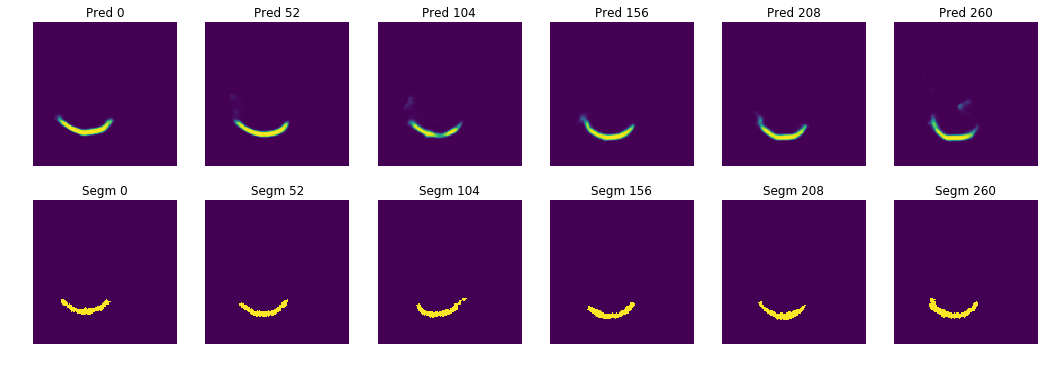

In [26]:
import matplotlib.pyplot as plt

pred_segmentation_data = model.predict(test_ultrasound_data)

num_samples = 6
image_indices = np.arange(0, num_test_ultrasound, int(num_test_ultrasound / (num_samples - 1)) - 1)

f = plt.figure(figsize=(18,6))

for i in range(num_samples):
    subplot = f.add_subplot(2, 6, i + 1)
    subplot.axis("Off")
    image_index = image_indices[i]
    plt.imshow(pred_segmentation_data[image_index, :, :, 0].astype(np.float32))
    plt.title("Pred " + str(image_index))

for i in range(num_samples):
    subplot = f.add_subplot(2, 6, 6 + i + 1)
    subplot.axis("Off")
    image_index = image_indices[i]
    plt.imshow(test_segmentation_data[image_index, :, :, 0].astype(np.float32))
    plt.title("Segm " + str(image_index))

plt.show()